In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr, pointbiserialr, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score



# Data Loading

In [2]:
df_original = pd.read_csv('../datasets/heart.csv')
df_original.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Data Cleaning



## valores ausentes

In [3]:
# Verificar si hay valores ausentes en los datos
print("Valores ausentes:")
print(df_original.isnull().sum())

# Variable categórica de interés
categoria = 'thall'

# Obtener los valores únicos de la variable categórica
valores_unicos = df_original[categoria].unique()

# Mostrar los valores únicos
print("Valores únicos de la variable '{}':".format(categoria))
for valor in valores_unicos:
    print(valor)


Valores ausentes:
age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64
Valores únicos de la variable 'thall':
1
2
3
0


Quizás los valores 0 de thall son ausentes? porque en una de las descripción:

0 = null
1 = fixed defect
2 = normal
3 = reversable defect

en ese caso, habría que tratarlos, no?

## outliers

Outliers en la variable 'age':
Empty DataFrame
Columns: [age, sex, cp, trtbps, chol, fbs, restecg, thalachh, exng, oldpeak, slp, caa, thall, output]
Index: []


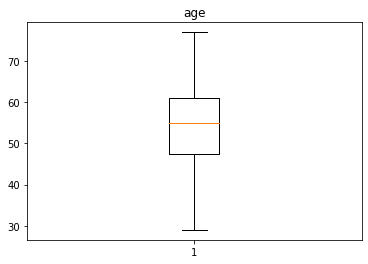

Outliers en la variable 'trtbps':
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
8     52    1   2     172   199    1        1       162     0      0.5    2   
101   59    1   3     178   270    0        0       145     0      4.2    0   
110   64    0   0     180   325    0        1       154     1      0.0    2   
203   68    1   2     180   274    1        0       150     1      1.6    1   
223   56    0   0     200   288    1        0       133     1      4.0    0   
241   59    0   0     174   249    0        1       143     1      0.0    1   
248   54    1   1     192   283    0        0       195     0      0.0    2   
260   66    0   0     178   228    1        1       165     1      1.0    1   
266   55    0   0     180   327    0        2       117     1      3.4    1   

     caa  thall  output  
8      0      3       1  
101    0      3       1  
110    0      2       1  
203    0      3       0  
223    2      3       0  
241    0      2    

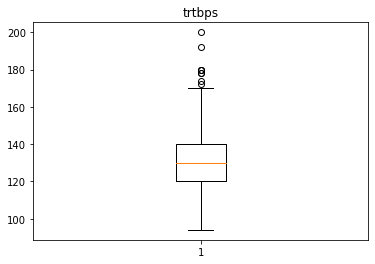

Outliers en la variable 'chol':
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
28    65    0   2     140   417    1        0       157     0      0.8    2   
85    67    0   2     115   564    0        0       160     0      1.6    1   
96    62    0   0     140   394    0        0       157     0      1.2    1   
220   63    0   0     150   407    0        0       154     0      4.0    1   
246   56    0   0     134   409    0        0       150     1      1.9    1   

     caa  thall  output  
28     1      2       1  
85     0      3       1  
96     0      2       1  
220    3      3       0  
246    2      3       0  


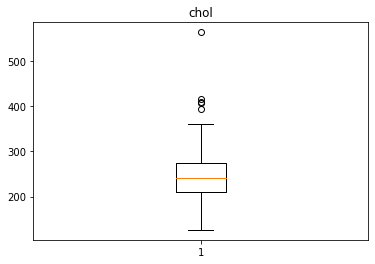

Outliers en la variable 'thalachh':
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
272   67    1   0     120   237    0        1        71     0      1.0    1   

     caa  thall  output  
272    0      2       0  


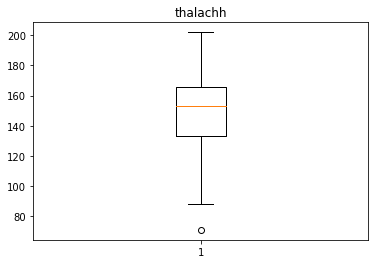

Outliers en la variable 'oldpeak':
     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
101   59    1   3     178   270    0        0       145     0      4.2    0   
204   62    0   0     160   164    0        0       145     0      6.2    0   
221   55    1   0     140   217    0        1       111     1      5.6    0   
250   51    1   0     140   298    0        1       122     1      4.2    1   
291   58    1   0     114   318    0        2       140     0      4.4    0   

     caa  thall  output  
101    0      3       1  
204    3      3       0  
221    0      3       0  
250    3      3       0  
291    3      1       0  


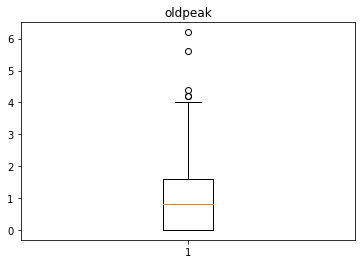

In [4]:
variables = ["age", "trtbps", "chol", "thalachh", "oldpeak"]

# Iterar sobre las variables para detectar y visualizar outliers
for variable in variables:
    # Calcular los límites utilizando el rango intercuartílico (IQR)
    Q1 = df_original[variable].quantile(0.25)
    Q3 = df_original[variable].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df_original[(df_original[variable] < lower_bound) | (df_original[variable] > upper_bound)]

    # Mostrar los outliers
    print("Outliers en la variable '{}':".format(variable))
    print(outliers)

    # Generar un box plot para visualizar los outliers
    plt.figure()
    plt.boxplot(df_original[variable])
    plt.title(variable)
    plt.show()

# Data Analysis

## Análisis descriptivo

In [5]:
# Obtener información sobre las variables del DataFrame
df_original.info()

# Obtener los tipos de datos de cada columna
print(df_original.dtypes)

# Convertir variables categóricas a tipo "categoría"
#df_original['sex'] = df_original['sex'].astype('category')
#df_original['cp'] = df_original['cp'].astype('category')
#df_original['fbs'] = df_original['fbs'].astype('category')
#df_original['restecg'] = df_original['restecg'].astype('category')
#df_original['exng'] = df_original['exng'].astype('category')
#df_original['slp'] = df_original['slp'].astype('category')
#df_original['caa'] = df_original['caa'].astype('category')
#df_original['thall'] = df_original['thall'].astype('category')
#df_original['output'] = df_original['output'].astype('category')

# Verificar los nuevos tipos de datos
print(df_original.dtypes)

# Ver los valores únicos de cada variable categórica
#print(df_original['sex'].cat.categories)
#print(df_original['cp'].cat.categories)
#print(df_original['fbs'].cat.categories)
#print(df_original['restecg'].cat.categories)
#print(df_original['exng'].cat.categories)
#print(df_original['slp'].cat.categories)
#print(df_original['caa'].cat.categories)
#print(df_original['thall'].cat.categories)
#print(df_original['output'].cat.categories)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64

In [6]:
# Obtener estadísticas descriptivas para todas las variables
df_original.describe()


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


## Análisis visual de la relación entre variables categóricas y los infartos



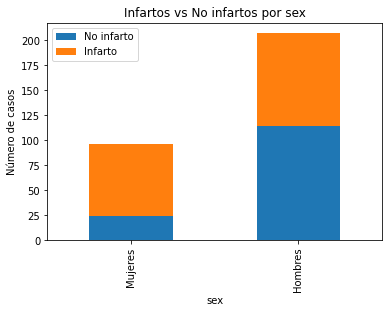

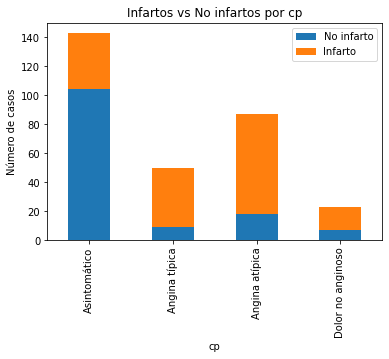

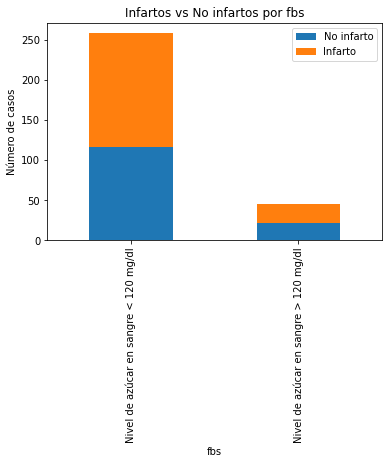

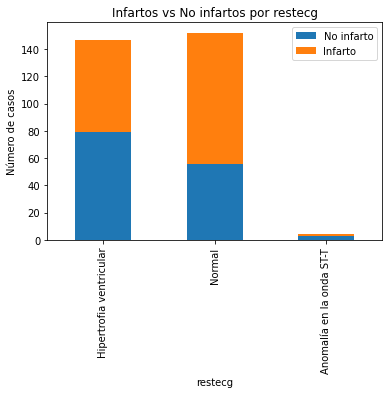

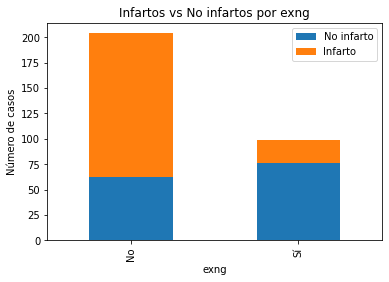

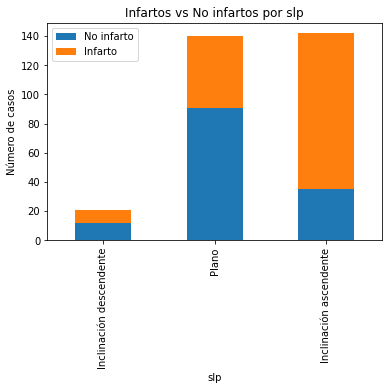

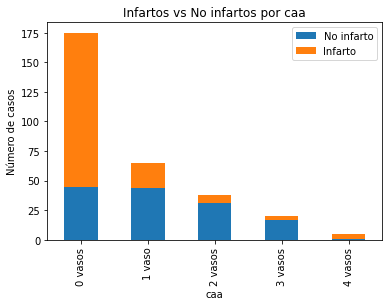

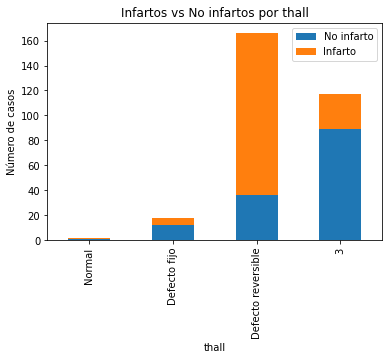

In [7]:
# Variables categóricas de interés
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']

# Diccionario con las etiquetas personalizadas para cada variable categórica
labels_dict = {
    'sex': {0: 'Mujeres', 1: 'Hombres'},
    'cp': {1: 'Angina típica', 2: 'Angina atípica', 3: 'Dolor no anginoso', 0: 'Asintomático'},
    'fbs': {0: 'Nivel de azúcar en sangre < 120 mg/dl', 1: 'Nivel de azúcar en sangre > 120 mg/dl'},
    'restecg': {1: 'Normal', 2: 'Anomalía en la onda ST-T', 0: 'Hipertrofia ventricular'},
    'exng': {0: 'No', 1: 'Sí'},
    'slp': {0: 'Inclinación descendente', 1: 'Plano', 2: 'Inclinación ascendente'},
    'caa': {0: '0 vasos', 1: '1 vaso', 2: '2 vasos', 3: '3 vasos', 4: '4 vasos'},
    'thall': {0: 'Normal', 1: 'Defecto fijo', 2: 'Defecto reversible'}
}

# Iterar sobre las variables categóricas
for var in categorical_vars:
    # Calcular el recuento de infartos y no infartos en cada categoría
    counts = df_original.groupby([var, 'output']).size().unstack().fillna(0)
    
    # Crear el gráfico de barras
    counts.plot(kind='bar', stacked=True)
    
    # Obtener las etiquetas para el eje x
    labels = counts.index
    
    # Verificar si la variable tiene etiquetas personalizadas en el diccionario y reemplazar las etiquetas correspondientes
    if var in labels_dict:
        labels = [labels_dict[var].get(label, label) for label in labels]
    
    # Personalizar la leyenda del gráfico
    plt.legend(['No infarto', 'Infarto'])
    
    # Personalizar el gráfico
    plt.xlabel(var)
    plt.ylabel('Número de casos')
    plt.title('Infartos vs No infartos por {}'.format(var))
    
    # Establecer las etiquetas en el eje x
    plt.xticks(range(len(labels)), labels)
    
    # Mostrar el gráfico
    plt.show()

# Pruebas de contraste de hipótesis
Para realizar las pruebas de hipótesis, es recomendable que los datos cumplan con los supuestos de normalidad y homogeneidad de varianzas. Sin embargo, en muestras grandes (como en este caso, con 303 registros), las pruebas pueden ser menos sensibles a estos supuestos y pueden ofrecer resultados confiables.

## Normalidad
Para verificar la normalidad, puedes usar gráficos de histogramas y gráficos Q-Q (quantile-quantile) para visualizar la distribución de los datos. Además, puedes aplicar pruebas estadísticas como la prueba de normalidad de Shapiro-Wilk o la prueba de normalidad de Kolmogorov-Smirnov para obtener evidencia cuantitativa de la normalidad de los datos.

## Homocedasticidad
Para verificar la homogeneidad de varianzas, puedes utilizar gráficos de dispersión y gráficos de caja para examinar la variabilidad de los datos entre los grupos. También puedes aplicar pruebas estadísticas como la prueba de Levene o la prueba de Bartlett para evaluar si hay diferencias significativas en las varianzas entre los grupos.

Dado que el objetivo principal de tu estudio es predecir la probabilidad de sufrir un ataque al corazón basado en las diferentes características del dataset, podemos realizar pruebas de contraste de hipótesis que evalúen la relación entre esas características y la variable objetivo "output". Algunas pruebas interesantes que podrías considerar son:

In [8]:
group1 = df_original[df_original['output'] == 0]
group2 = df_original[df_original['output'] == 1]

### Age
Comparamos la edad (Age) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa en la edad entre los dos grupos.

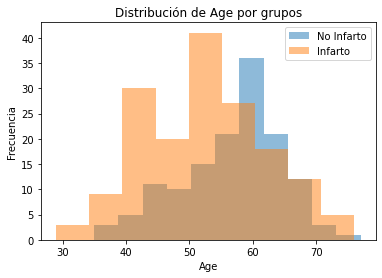

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.002868534531444311
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.12112646549940109


In [9]:
# Realizar pruebas de normalidad
group1_age = group1['age']
group2_age = group2['age']

# Verificación de la normalidad
plt.figure()
plt.hist(group1_age, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_age, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Age')
plt.ylabel('Frecuencia')
plt.title('Distribución de Age por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_age)
_, p_value2 = stats.shapiro(group2_age)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)


Los resultados de la prueba de normalidad (Shapiro-Wilk) indican que para el grupo 1, la variable 'Age' no sigue una distribución normal (p-value = 0.0029), mientras que para el grupo 2, la variable 'Age' sí sigue una distribución normal (p-value = 0.1211). Esto sugiere que el grupo 1 no cumple con el supuesto de normalidad, mientras que el grupo 2 sí cumple con este supuesto.

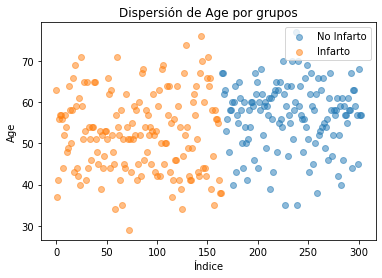

Prueba de homogeneidad de varianzas (Levene): p-value = 0.005030946112241428


In [10]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_age, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_age, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Age')
plt.title('Dispersión de Age por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_age, group2_age)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El resultado de la prueba de homogeneidad de varianzas (Levene) indica que existe una diferencia significativa en las varianzas entre los dos grupos (p-value = 0.0050). Esto significa que el supuesto de homogeneidad de varianzas no se cumple en este caso.

Dado que tanto el supuesto de normalidad como el supuesto de homogeneidad de varianzas no se cumplen en este análisis, podríamos optar por utilizar una alternativa no paramétrica, como las pruebas de Wilcoxon o Mann-Whitney, pero esto generalmente implica la pérdida de potencia estadística. Por ello, existe otra alternativa previa al uso de pruebas no paramétricas que consiste en convertir los datos para tratar de mejorar su normalidad y homocedasticidad: la transformación (o familia de transformaciones) de Box-Cox.

En este caso, vamos a realizarla esta transformación: 

In [11]:
# Transformación de Box-Cox en 'Age'
age_transformed, lambda_val = stats.boxcox(df_original['age'])

# Separar los grupos basados en la variable 'output'
group1_age_transformed = age_transformed[df_original['output'] == 0]
group2_age_transformed = age_transformed[df_original['output'] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)


Valor óptimo de lambda: 1.4117531035524666


Ahora que hemos realizado la transformación de Box-Cox en la variable 'age', podemos realizar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y luego aplicar las pruebas paramétricas, como la prueba t de Student:

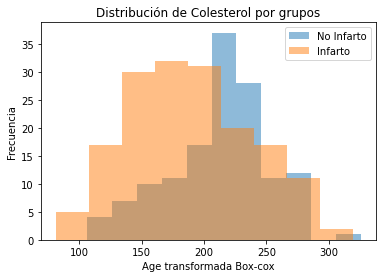

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.02191431261599064
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.030850721523165703


In [12]:
# Verificación de la normalidad
plt.figure()
plt.hist(group1_age_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_age_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Age transformada Box-cox')
plt.ylabel('Frecuencia')
plt.title('Distribución de Colesterol por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_age_transformed)
_, p_value2 = stats.shapiro(group2_age_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Después de aplicar la transformación de Box-Cox a la variable "age", los resultados de las pruebas de normalidad (Shapiro-Wilk) son los siguientes:

Para el grupo 1: p-value = 0.0219

Para el grupo 2: p-value = 0.0308

Estos valores de p son menores que el nivel de significancia comúnmente utilizado (0.05), lo que sugiere que los datos transformados no siguen una distribución normal en ninguno de los grupos.

Dado que los datos transformados tampoco cumplen el supuesto de normalidad, es recomendable utilizar pruebas no paramétricas.

Una opción podría ser la prueba U de Mann-Whitney como alternativa a la prueba t de dos muestras independientes. Esta prueba no requiere el supuesto de normalidad ni el supuesto de homogeneidad de varianzas:

In [13]:
from scipy.stats import mannwhitneyu

# Prueba U de Mann-Whitney
statistic, p_value = mannwhitneyu(group1_age, group2_age)
print('Prueba U de Mann-Whitney (Age):')
print('Estadístico U =', statistic)
print('Valor p =', p_value)

Prueba U de Mann-Whitney (Age):
Estadístico U = 8240.5
Valor p = 1.7192551591614436e-05


El resultado de la prueba U de Mann-Whitney para la variable 'Age' indica que hay una diferencia significativa en la edad promedio entre los dos grupos (p-value = 1.719e-05). Esto sugiere que la edad puede ser un factor importante en la probabilidad de sufrir un ataque al corazón.

El valor p es menor que el umbral de significancia comúnmente utilizado (0.05), lo que indica que hay evidencia estadística para rechazar la hipótesis nula de que no hay diferencia en la edad entre los dos grupos.

### Colesterol
Comparamos el colesterol (chol) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa en el índice de colesterol entre los dos grupos.

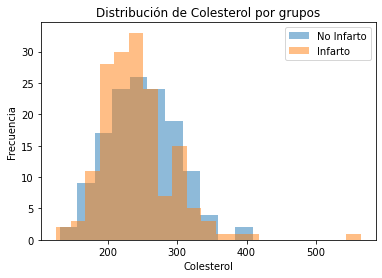

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.3792019188404083
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 3.0788867011466436e-09


In [14]:
# Realizar pruebas de normalidad
group1_chol = group1['chol']
group2_chol = group2['chol']

# Verificación de la normalidad
plt.figure()
plt.hist(group1_chol, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_chol, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Colesterol')
plt.ylabel('Frecuencia')
plt.title('Distribución de Colesterol por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_chol)
_, p_value2 = stats.shapiro(group2_chol)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Para el grupo 1 (menor probabilidad de sufrir un ataque al corazón), el valor p de la prueba de normalidad (Shapiro-Wilk) es 0.3792. Dado que este valor p es mayor que el nivel de significancia comúnmente utilizado (0.05), no tenemos suficiente evidencia para rechazar la hipótesis nula de normalidad. Por lo tanto, podemos considerar que la variable 'chol' en el grupo 1 sigue una distribución normal.

Para el grupo 2 (mayor probabilidad de sufrir un ataque al corazón), el valor p de la prueba de normalidad (Shapiro-Wilk) es 3.0789e-09. Este valor p es menor que el nivel de significancia, lo que indica que tenemos suficiente evidencia para rechazar la hipótesis nula de normalidad. Por lo tanto, podemos concluir que la variable 'chol' en el grupo 2 no sigue una distribución normal

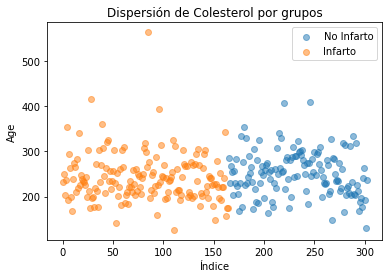

Prueba de homogeneidad de varianzas (Levene): p-value = 0.7503013119536862


In [15]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_chol, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_chol, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Age')
plt.title('Dispersión de Colesterol por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_chol, group2_chol)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El resultado de la prueba de homogeneidad de varianzas (Levene) indica que existe una diferencia significativa en las varianzas entre los dos grupos (p-value = 0.0050). Esto significa que el supuesto de homogeneidad de varianzas no se cumple en este caso.

Dado que tanto el supuesto de normalidad como el supuesto de homogeneidad de varianzas no se cumplen en este análisis, vamos a proceder como con la variable Age, realizaremos la transformación Box-cox, primero:

In [16]:
# Transformación de Box-Cox en 'chol'
chol_transformed, lambda_val = stats.boxcox(df_original['chol'])

# Separar los grupos basados en la variable 'target'
group1_chol_transformed = chol_transformed[df_original['output'] == 0]
group2_chol_transformed = chol_transformed[df_original['output'] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)


Valor óptimo de lambda: -0.10592568145157065


Ahora que hemos realizado la transformación de Box-Cox en la variable 'chol', podemos realizar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y luego aplicar las pruebas paramétricas, como la prueba t de Student:

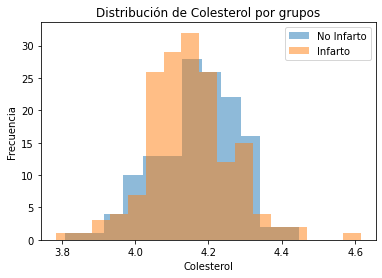

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.3013194501399994
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.03505672886967659


In [17]:
# Verificación de la normalidad
plt.figure()
plt.hist(group1_chol_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_chol_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Colesterol')
plt.ylabel('Frecuencia')
plt.title('Distribución de Colesterol por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_chol_transformed)
_, p_value2 = stats.shapiro(group2_chol_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Dado que los datos transformados de chol tampoco cumplen el supuesto de normalidad, realizamos la prueba U de Mann-Whitney como alternativa a la prueba t de dos muestras independientes:

In [18]:
# Prueba U de Mann-Whitney
statistic, p_value = mannwhitneyu(group1_chol, group2_chol)
print('Prueba U de Mann-Whitney (chol):')
print('Estadístico U =', statistic)
print('Valor p =', p_value)

Prueba U de Mann-Whitney (chol):
Estadístico U = 9789.5
Valor p = 0.017857591005688206


Este resultado indica que hay una diferencia estadísticamente significativa en los niveles de colesterol promedio entre los grupos de pacientes con menor y mayor probabilidad de sufrir un ataque al corazón. El valor p es menor que el nivel de significancia comúnmente utilizado de 0.05, lo que sugiere que la diferencia observada en los niveles de colesterol entre los dos grupos no se puede atribuir al azar.

En resumen, este resultado indica que los niveles de colesterol pueden ser un factor importante en la probabilidad de sufrir un ataque al corazón, ya que hay diferencias significativas en los niveles de colesterol promedio entre los grupos con menor y mayor probabilidad.

### Presión arterial en reposo (trtbps).
Comparamos la presión arterial (trtbps) promedio entre los pacientes con menor probabilidad de sufrir un ataque al corazón (target = 0) y los pacientes con mayor probabilidad de sufrir un ataque al corazón (target = 1). Esto podría ayudar a determinar si existe una diferencia significativa entre los dos grupos.

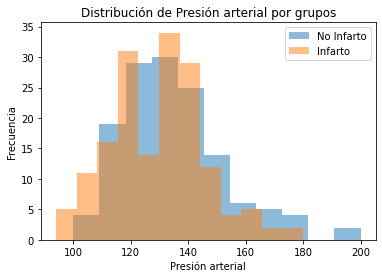

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 8.36556137073785e-05
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.01190413162112236


In [19]:
# Realizar pruebas de normalidad
group1_trtbps = group1['trtbps']
group2_trtbps = group2['trtbps']

# Verificación de la normalidad
plt.figure()
plt.hist(group1_trtbps, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_trtbps, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Presión arterial')
plt.ylabel('Frecuencia')
plt.title('Distribución de Presión arterial por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_trtbps)
_, p_value2 = stats.shapiro(group2_trtbps)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

Dado que los datos no cumplen con la normalidad en ambos grupos, vamos a realizar la transformación Box-cox:

In [20]:
# Transformación de Box-Cox en 'trtbps'
trtbps_transformed, lambda_val = stats.boxcox(df_original['trtbps'])

# Separar los grupos basados en la variable 'target'
group1_trtbps_transformed = trtbps_transformed[df_original['output'] == 0]
group2_trtbps_transformed = trtbps_transformed[df_original['output'] == 1]

# Imprimir el valor óptimo de lambda
print("Valor óptimo de lambda:", lambda_val)


Valor óptimo de lambda: -0.6969418904300226


Ahora que hemos realizado la transformación de Box-Cox en la variable 'trtbps', podemos realizar las pruebas de normalidad y homogeneidad de varianzas en los datos transformados y luego aplicar las pruebas paramétricas, como la prueba t de Student:

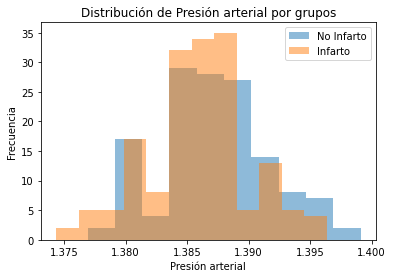

Prueba de normalidad (Shapiro-Wilk) para group1: p-value = 0.19684943556785583
Prueba de normalidad (Shapiro-Wilk) para group2: p-value = 0.08560237288475037


In [21]:
# Verificación de la normalidad
plt.figure()
plt.hist(group1_trtbps_transformed, bins='auto', alpha=0.5, label='No Infarto')
plt.hist(group2_trtbps_transformed, bins='auto', alpha=0.5, label='Infarto')
plt.xlabel('Presión arterial')
plt.ylabel('Frecuencia')
plt.title('Distribución de Presión arterial por grupos')
plt.legend()
plt.show()

_, p_value1 = stats.shapiro(group1_trtbps_transformed)
_, p_value2 = stats.shapiro(group2_trtbps_transformed)
print('Prueba de normalidad (Shapiro-Wilk) para group1: p-value =', p_value1)
print('Prueba de normalidad (Shapiro-Wilk) para group2: p-value =', p_value2)

En ambos casos, los valores p son mayores que el nivel de significancia comúnmente utilizado de 0.05, lo que indica que los datos podrían seguir una distribución normal en ambos grupos. 

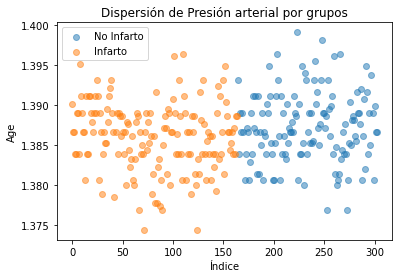

Prueba de homogeneidad de varianzas (Levene): p-value = 0.5746765109778397


In [22]:
# Verificación de homogeneidad de varianzas
plt.figure()
plt.scatter(group1.index, group1_trtbps_transformed, alpha=0.5, label='No Infarto')
plt.scatter(group2.index, group2_trtbps_transformed, alpha=0.5, label='Infarto')
plt.xlabel('Índice')
plt.ylabel('Age')
plt.title('Dispersión de Presión arterial por grupos')
plt.legend()
plt.show()

_, p_value = stats.levene(group1_trtbps_transformed, group2_trtbps_transformed)
print('Prueba de homogeneidad de varianzas (Levene): p-value =', p_value)

El valor p obtenido es mayor que el nivel de significancia de 0.05, lo que sugiere que no hay evidencia suficiente para rechazar la hipótesis nula de igualdad de varianzas entre los dos grupos. Por lo tanto, se puede asumir que las varianzas de la variable "trtbps" son homogéneas en ambos grupos.

Por lo tanto, podemos aplcar un 


In [23]:
# Realizar prueba t de dos muestras independientes
statistic, p_value = ttest_ind(group1_trtbps_transformed, group2_trtbps_transformed)

# Imprimir resultados
print("Prueba t de dos muestras independientes (trtbps):")
print("Estadístico t =", statistic)
print("Valor p =", p_value)

Prueba t de dos muestras independientes (trtbps):
Estadístico t = 2.460986181580469
Valor p = 0.01441666838690425


Como en las anteriores variables estudiadas, el resultado indica que hay una diferencia significativa en los promedios de la variable "trtbps" entre los dos grupos (menor probabilidad de sufrir un ataque al corazón y mayor probabilidad de sufrir un ataque al corazón) después de aplicar la transformación de Box-Cox.

# Pruebas de asociación entre variables categóricas

Para realizar las pruebas asociación entre variables categóricas, los datos deben cumplir:

## Independencia de las observaciones
Esto significa que las categorías o valores observados para un individuo no deben estar relacionados o influir en las categorías o valores observados para otros individuos. Esta condición se asume generalmente en estudios de muestreo aleatorio o en diseños experimentales adecuados.

## Tamaño de muestra adecuado
Tamaño de muestra adecuado: Verifica que cada categoría o nivel de las variables categóricas tenga un número suficiente de observaciones. Se recomienda que ninguna frecuencia esperada sea menor de 5.

## Frecuencias esperadas adecuadas
Se calculan las frecuencias esperadas para cada combinación de categorías. Utilizaremos métodos como el cálculo de las frecuencias marginales y aplicar la fórmula de la distribución chi cuadrado para obtener las frecuencias esperadas.


### Tipo de dolor en el pecho (cp)
Vamos a considerar aplicar el test de chi cuadrado para evaluar si existe una asociación significativa entre la presencia de ataque al corazón (variable target) y el tipo de dolor en el pecho (variable cp). Esto te permitiría investigar si el tipo de dolor en el pecho está relacionado con la probabilidad de sufrir un ataque al corazón.


In [24]:
# Comprobación de tamaño de muestra adecuado
frecuencias_obs = pd.crosstab(df_original['cp'], df_original['output'])
print("Frecuencias observadas:")
print(frecuencias_obs)

# Comprobación de frecuencias esperadas adecuadas
frecuencias_esp = chi2_contingency(frecuencias_obs)[3]
print("Frecuencias esperadas:")
print(frecuencias_esp)

Frecuencias observadas:
output    0   1
cp             
0       104  39
1         9  41
2        18  69
3         7  16
Frecuencias esperadas:
[[65.12871287 77.87128713]
 [22.77227723 27.22772277]
 [39.62376238 47.37623762]
 [10.47524752 12.52475248]]


Observamos que todas las categorías tienen un número de observaciones mayor o igual a 5, por lo que en principio el tamaño de la muestra parece ser adecuado para realizar el test de chi cuadrado.

In [25]:
# Comprobación de independencia
chi2, p_valor, _, _ = chi2_contingency(frecuencias_obs)
print("Estadístico Chi cuadrado:", chi2)
print("Valor p:", p_valor)

Estadístico Chi cuadrado: 81.68642755194445
Valor p: 1.3343043373050064e-17


El estadístico chi cuadrado es una medida que indica la discrepancia entre las frecuencias observadas y las frecuencias esperadas en una tabla de contingencia.

En este caso, un valor alto del estadístico chi cuadrado (como 81.686) indica que hay una gran discrepancia entre las frecuencias observadas y las esperadas, lo que sugiere una asociación significativa entre las variables.



# Analizar Multicolinealidad: Pruebas de correlación

## Prueba de correlación de Pearson
La prueba de correlación de Pearson nos permite evaluar la correlación lineal entre variables numéricas. Nos dará una idea de la fuerza y dirección de la relación lineal entre las variables.

El coeficiente de correlación de Pearson es el más utilizado entre variables relacionadas linealmente. No obstante, para poder aplicarse, requiere que la distribución de ambas variables sea normal, así como que se cumpla el criterio de homocedasticidad.

## Prueba de correlación de Spearman
La prueba de correlación de Spearman nos permite evaluar la correlación entre variables, tanto numéricas como categóricas, utilizando el rango de los datos en lugar de los valores exactos. Es útil para detectar relaciones no lineales o monotónicas entre variables.

La correlación de Spearman aparece como una alternativa no paramétrica que mide el grado de dependencia entre dos variables. Este método no conlleva ninguna suposición sobre la distribución de los datos, aunque las variables a comparar deben medirse al menos en una escala ordinal.

## VIF (Factor de Inflación de la Varianza)
El VIF es una medida de multicolinealidad, que indica cuánto se ve afectada la varianza de un predictor debido a la multicolinealidad con otros predictores.


Matriz de correlación de Pearson:
               age    trtbps      chol  thalachh   oldpeak
age       1.000000  0.279351  0.213678 -0.398522  0.210013
trtbps    0.279351  1.000000  0.123174 -0.046698  0.193216
chol      0.213678  0.123174  1.000000 -0.009940  0.053952
thalachh -0.398522 -0.046698 -0.009940  1.000000 -0.344187
oldpeak   0.210013  0.193216  0.053952 -0.344187  1.000000


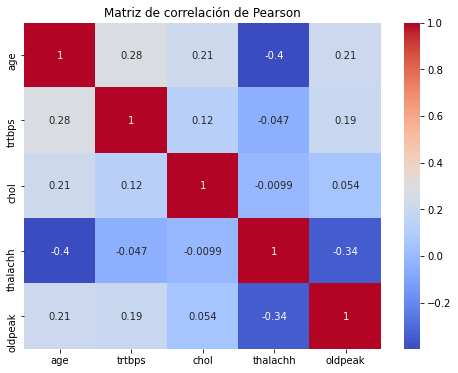

In [26]:
# Realizar la prueba de correlación de Pearson
corr_pearson = df_original[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']].corr()

# Matriz de correlación de Pearson
print("Matriz de correlación de Pearson:")
print(corr_pearson)

# Mapa de calor de la matriz de correlación de Pearson
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación de Pearson")
plt.show()

En resumen, la edad, la presión arterial en reposo, el colesterol y el pico de frecuencia cardíaca alcanzado durante el estrés parecen tener cierta correlación entre sí, aunque algunas de estas correlaciones son débiles.

Matriz de correlación de Spearman:
[[ 1.          0.28561681  0.19578599 -0.39805244  0.26829122]
 [ 0.28561681  1.          0.12656163 -0.04040735  0.15426674]
 [ 0.19578599  0.12656163  1.         -0.04676639  0.0452596 ]
 [-0.39805244 -0.04040735 -0.04676639  1.         -0.43324053]
 [ 0.26829122  0.15426674  0.0452596  -0.43324053  1.        ]]


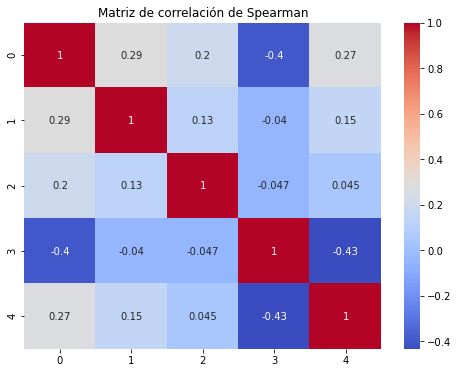

In [27]:
# Realizar la prueba de correlación de Spearman
corr_spearman, _ = spearmanr(df_original[['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']])

# Matriz de correlación de Spearman
print("Matriz de correlación de Spearman:")
print(corr_spearman)

# Mapa de calor de la matriz de correlación de Spearman
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación de Spearman")
plt.show()

La matriz de correlación de Spearman muestra las correlaciones entre las variables edad, presión arterial en reposo (trtbps), colesterol (chol), frecuencia cardíaca máxima alcanzada (thalachh) y depresión del segmento ST inducida por el ejercicio en relación con el reposo (oldpeak).

Algunas observaciones de la matriz de correlación de Spearman son:

- La correlación entre la edad y la presión arterial en reposo es moderada positiva (0.2856), lo que indica que a medida que la edad aumenta, también tiende a aumentar la presión arterial en reposo.

- La correlación entre la edad y el colesterol es baja positiva (0.1958), lo que sugiere una relación débil entre la edad y el colesterol.

- La correlación entre la edad y la frecuencia cardíaca máxima alcanzada es moderada negativa (-0.3981), lo que indica que a medida que la edad aumenta, tiende a disminuir la frecuencia cardíaca máxima alcanzada.

- La correlación entre la edad y la depresión del segmento ST inducida por el ejercicio es moderada positiva (0.2683), lo que sugiere una relación débil entre la edad y la depresión del segmento ST.

In [38]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Obtener las variables predictoras sin la columna de salida (output)
X = df_original[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']]

# Añadir una columna de intercepto al conjunto de datos
#X_with_intercept = sm.add_constant(X)

# Calcular el VIF para cada variable predictora
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [calculate_vif_single(X, col) for col in X.columns]
    return vif

def calculate_vif_single(X, col):
    cols = X.columns.tolist()
    cols.remove(col)
    model = LinearRegression().fit(X[cols], X[col])
    r_squared = model.score(X[cols], X[col])
    vif = 1 / (1 - r_squared)
    return vif


# Mostrar el resultado del cálculo del VIF
#vif = calculate_vif(X_with_intercept)
vif = calculate_vif(X)
print(vif)


    Variable       VIF
0      const       inf
1        age  1.443474
2        sex  1.161866
3         cp  1.284456
4     trtbps  1.170591
5       chol  1.150174
6        fbs  1.087379
7    restecg  1.060998
8   thalachh  1.613726
9       exng  1.402001
10   oldpeak  1.705857
11       slp  1.642595
12       caa  1.202570
13     thall  1.147279


<ipython-input-38-24dde1a62878>:23: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1 / (1 - r_squared)


In [39]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Obtener las variables predictoras
X = df_original[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']]

# Calcular el VIF para cada variable predictora
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

    Variable        VIF
0        age  38.998305
1        sex   3.523211
2         cp   2.414403
3     trtbps  58.557335
4       chol  26.267365
5        fbs   1.268205
6    restecg   2.058206
7   thalachh  42.742178
8       exng   2.022527
9    oldpeak   3.062890
10       slp  10.072734
11       caa   1.808925
12     thall  17.165303


En general, si el VIF es menor a 5, se considera que no hay una multicolinealidad significativa. En tu caso, todos los valores de VIF están por debajo de 5, lo que sugiere que no hay una alta multicolinealidad entre las variables predictoras.

En conclusión, no sería necesario eliminar ninguna variable del conjunto de datos debido a la multicolinealidad, ya que todas las variables tienen un VIF bajo y no hay una alta correlación entre ellas.

# Modelos de clasificación

Para realizar un modelo de clasificación, necesitamos dividir el conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba. El conjunto de entrenamiento se utilizará para entrenar el modelo y el conjunto de prueba se utilizará para evaluar su rendimiento.

In [29]:
# Dividir el conjunto de datos en variables predictoras (X) y variable objetivo (y)
X = df_original[['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']]
y = df_original['output']

# Codificar las variables categóricas como variables dummy
#X = pd.get_dummies(X, drop_first=True)

# Fijar la semilla para reproducibilidad
random_state = 42

# Dividir el conjunto de datos en entrenamiento y prueba con la misma semilla
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


## Modelo de regresión logística

In [30]:
# Crear el modelo de regresión logística con la misma semilla
model_logistic_regression = LogisticRegression(random_state=random_state)

# Entrenar el modelo
model_logistic_regression.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_logistic_regression = model_logistic_regression.predict(X_test)

# Calcular la precisión del modelo
accuracy_logistic_regression = accuracy_score(y_test, y_pred_logistic_regression)
print("Precisión del modelo:", accuracy_logistic_regression)

# Calcular la recall del modelo
recall_logistic_regression = recall_score(y_test, y_pred_logistic_regression)
print("Recall del modelo:", recall_logistic_regression)

# Calcular la F1-score de cada modelo
f1_logistic_regression = f1_score(y_test, y_pred_logistic_regression)
print("F1-score del modelo:", f1_logistic_regression)

# Calcular la matriz de confusión
confusion_matrix_logistic_regression = confusion_matrix(y_test, y_pred_logistic_regression)
print("Matriz de confusión:")
print(confusion_matrix_logistic_regression)


Precisión del modelo: 0.8852459016393442
Recall del modelo: 0.90625
F1-score del modelo: 0.8923076923076922
Matriz de confusión:
[[25  4]
 [ 3 29]]


/Users/cesar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


El resultado de la precisión del modelo es del 88.52%, lo cual indica que el modelo es capaz de predecir correctamente el 88.52% de los casos en el conjunto de prueba. Sin embargo, es importante considerar otros indicadores de rendimiento del modelo, como la matriz de confusión.

La interpretación de la matriz de confusión es la siguiente:

- Verdaderos positivos (TP): 25
- Falsos positivos (FP): 4
- Falsos negativos (FN): 3
- Verdaderos negativos (TN): 29


- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 25 casos y ha cometido 4 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 29 casos y ha cometido 3 falsos negativos (clasificados incorrectamente como "0").

En resumen, el modelo muestra un buen rendimiento en términos de precisión, pero es importante prestar atención a los falsos positivos y falsos negativos, ya que pueden tener implicaciones clínicas significativas dependiendo del contexto del problema.

Calculamos la curva ROC utilizando el modelo de regresión logística:

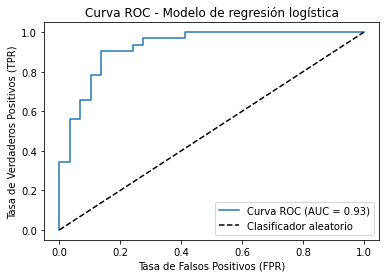

In [31]:
# Obtener las probabilidades de clase para el conjunto de prueba
probs = model_logistic_regression.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calcular el área bajo la curva ROC (AUC)
auc = roc_auc_score(y_test, probs)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo de regresión logística')
plt.legend()
plt.show()

## Modelo de árboles de decisión 


In [32]:
from sklearn.tree import DecisionTreeClassifier

# Crear el modelo de árboles de decisión con la misma semilla
model_decision_tree = DecisionTreeClassifier(random_state=random_state)

# Entrenar el modelo
model_decision_tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_decision_tree = model_decision_tree.predict(X_test)

# Calcular la precisión del modelo
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
print("Precisión del modelo de Árboles de Decisión:", accuracy_decision_tree)

# Calcular la recall del modelo
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
print("Recall del modelo:", recall_decision_tree)

# Calcular la F1-score de cada modelo
f1_decision_tree = f1_score(y_test, y_pred_decision_tree)
print("F1-score del modelo:", f1_decision_tree)

# Calcular la matriz de confusión
confusion_matrix_decision_tree = confusion_matrix(y_test, y_pred_decision_tree)
print("Matriz de confusión del modelo de Árboles de Decisión:")
print(confusion_matrix_decision_tree)


Precisión del modelo de Árboles de Decisión: 0.7540983606557377
Recall del modelo: 0.65625
F1-score del modelo: 0.736842105263158
Matriz de confusión del modelo de Árboles de Decisión:
[[25  4]
 [11 21]]


El modelo de Árboles de Decisión ha alcanzado una precisión del 75.41% en el conjunto de prueba. 

La matriz de confusión indica los siguientes resultados:

- Verdaderos positivos (TP): 25
- Falsos positivos (FP): 4
- Falsos negativos (FN): 11
- Verdaderos negativos (TN): 21

Es decir,

- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 25 casos y ha cometido 4 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 21 casos y ha cometido 11 falsos negativos (clasificados incorrectamente como "0").


Calculamos la curva ROC utilizando el modelo de árboles de decisión:

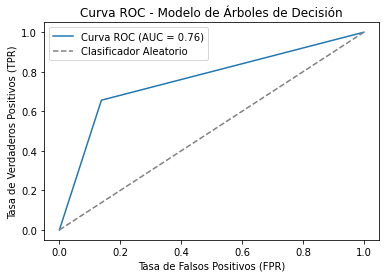

In [33]:
# Obtener las probabilidades de predicción del modelo
y_pred_proba = model_decision_tree.predict_proba(X_test)[:, 1]

# Calcular la tasa de verdaderos positivos (TPR), la tasa de falsos positivos (FPR) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo de Árboles de Decisión')
plt.legend()
plt.show()

In [34]:
## Modelo de Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Crear el modelo de Random Forest con la misma semilla
model_random_forest = RandomForestClassifier(random_state=random_state)

# Entrenar el modelo
model_random_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_random_forest = model_random_forest.predict(X_test)

# Calcular la precisión del modelo
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Precisión del modelo:", accuracy_random_forest)

# Calcular la recall del modelo
recall_random_forest = recall_score(y_test, y_pred_random_forest)
print("Recall del modelo:", recall_random_forest)

# Calcular la F1-score de cada modelo
f1_random_forest = f1_score(y_test, y_pred_random_forest)
print("F1-score del modelo:", f1_random_forest)

# Calcular la matriz de confusión
confusion_matrix_random_forest = confusion_matrix(y_test, y_pred_random_forest)
print("Matriz de confusión:")
print(confusion_matrix_random_forest)


Precisión del modelo: 0.8360655737704918
Recall del modelo: 0.84375
F1-score del modelo: 0.84375
Matriz de confusión:
[[24  5]
 [ 5 27]]


El modelo de Random Forest ha alcanzado una precisión del 83.60% en el conjunto de prueba. 

La matriz de confusión indica los siguientes resultados:

- Verdaderos positivos (TP): 24
- Falsos positivos (FP): 5
- Falsos negativos (FN): 5
- Verdaderos negativos (TN): 27

Es decir,

- En la clase "0" (sin riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 24 casos y ha cometido 5 falsos positivos (clasificados incorrectamente como "1").

- En la clase "1" (con riesgo de sufrir un ataque al corazón), el modelo ha clasificado correctamente 27 casos y ha cometido 5 falsos negativos (clasificados incorrectamente como "0").


Calculamos la curva ROC utilizando el modelo de Random Forest:

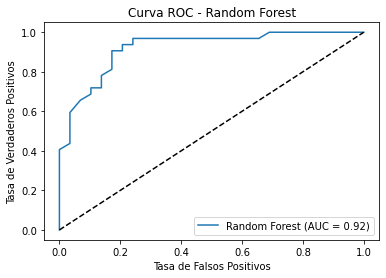

In [36]:
# Obtener las probabilidades de predicción para la clase positiva
y_prob = model_random_forest.predict_proba(X_test)[:, 1]

# Calcular la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calcular el área bajo la curva ROC (AUC-ROC)
auc = roc_auc_score(y_test, y_prob)

# Graficar la curva ROC
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia (AUC = 0.5)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()
